In [1]:
# ─────────────────────────────────────────────
# 1 : Librairies
# ─────────────────────────────────────────────

# Classic
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import polars as pl

# Probabilities
from scipy.optimize import curve_fit
from tls.probabilities import proba_gamma

popt [mu, theta, A]: [37.89810256 17.99604862  0.92443102]


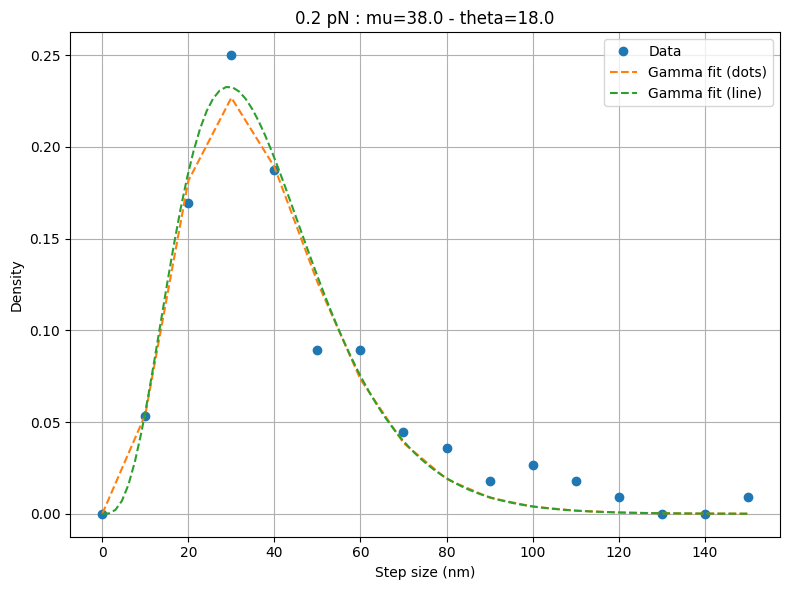


 mu_ryu_bp = 182.0 
 theta_ryu_bp = 91.0

 mu_nm = 60 
 theta_nm = 30


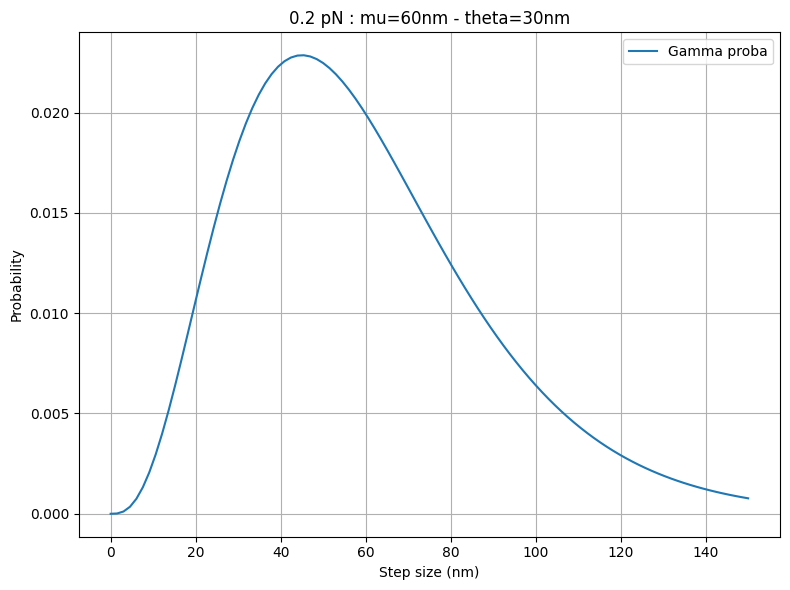

l (entier) : [450 332 261 213 178 152 131 115 101  90  81  72  65  59  54  49  44  40
  37  34  31  28  25  23  21  19  17  15  14  12  11   9   8   7   6   5
   4   3   2   1]
d après arrondi l : [0.00206186 0.0027248  0.00337838 0.00403226 0.00469484 0.00534759
 0.0060241  0.00666667 0.00735294 0.008      0.00862069 0.00934579
 0.01       0.0106383  0.01123596 0.01190476 0.01265823 0.01333333
 0.01388889 0.01449275 0.01515152 0.01587302 0.01666667 0.01724138
 0.01785714 0.01851852 0.01923077 0.02       0.02040816 0.0212766
 0.02173913 0.02272727 0.02325581 0.02380952 0.02439024 0.025
 0.02564103 0.02631579 0.02702703 0.02777778]


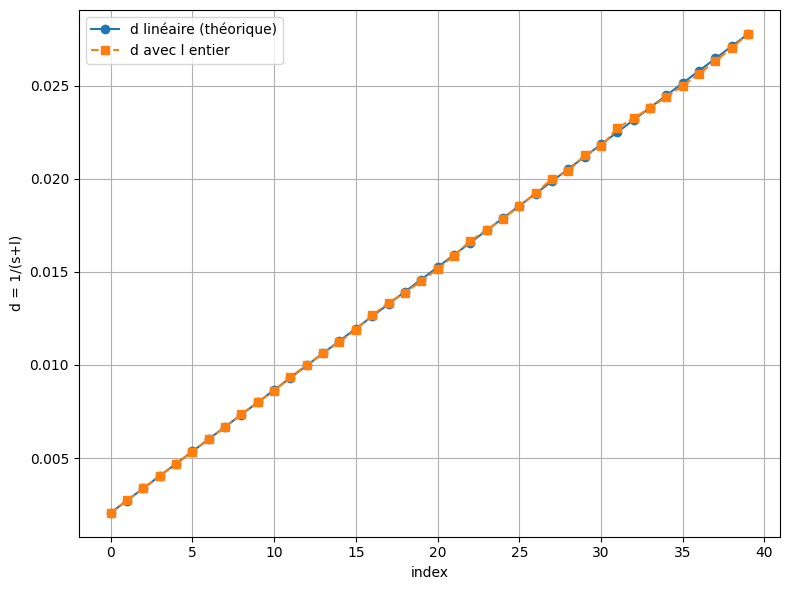

In [75]:
# ─────────────────────────────────────────────
# 2.1 : Ryu Datas
# ─────────────────────────────────────────────

# Datas
data = np.array([1, 0, 0, 1, 2, 3, 2, 4, 5, 10, 10, 21, 28, 19, 6, 0])
y_data = data[::-1] / np.sum(data)
x_data = np.arange(0, 150 + 1, 10).astype(float)
x_safe = x_data.copy()
x_safe[0] = 1e-6

# Filtering
def proba_gamma_fit_counts(x, mu, theta, A):
    y = proba_gamma(mu, theta, x)
    y = np.where(np.isfinite(y), y, 0.0)
    return A * y

# First guesses
A0 = float(y_data.sum())
mu0, theta0 = 30.0, 20.0

# Fitting
popt, pcov = curve_fit(
    proba_gamma_fit_counts,
    x_safe,
    y_data,
    p0=[mu0, theta0, A0],
    bounds=([1e-6, 1e-6, 1e-6], [np.inf, np.inf, np.inf]),
)
print("popt [mu, theta, A]:", popt)

# Fine curve
x_step = 100
x_fine = np.linspace(x_data.min(), x_data.max(), x_step)
y_fine = proba_gamma(popt[0], popt[1], x_fine)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(x_data, y_data, 'o', label="Data")
plt.plot(x_data, proba_gamma_fit_counts(x_safe, *popt), '--', label="Gamma fit (dots)")
plt.plot(x_fine, y_fine*x_step/len(x_data), '--', label="Gamma fit (line)")
plt.title(f"0.2 pN : mu={np.round(popt[0])} - theta={np.round(popt[1])}")
plt.xlabel("Step size (nm)")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# ─────────────────────────────────────────────
# 2.2 : Conversions
# ─────────────────────────────────────────────

# From nm_in_ryu to bp_in_ryu
mu_ryu_nm = 40     # nm Ryu
theta_ryu_nm = 20  # nm Ryu
ryu_nm_per_bp = 0.220
mu_ryu_bp = mu_ryu_nm / ryu_nm_per_bp
theta_ryu_bp = theta_ryu_nm / ryu_nm_per_bp
print(f"\n mu_ryu_bp = {np.round(mu_ryu_bp)} \n theta_ryu_bp = {np.round(theta_ryu_bp)}")

# From bp_in_ryu to nm
bp_per_nm = 3
mu_nm = int(mu_ryu_bp / bp_per_nm)
theta_nm = int(theta_ryu_bp / bp_per_nm)
print(f"\n mu_nm = {np.round(mu_nm)} \n theta_nm = {np.round(theta_nm)}")

# Plot
plt.figure(figsize=(8, 6))
plt.plot(x_fine, proba_gamma(mu_nm, theta_nm, x_fine), '-', label="Gamma proba")
plt.title(f"0.2 pN : mu={mu_nm}nm - theta={theta_nm}nm")
plt.xlabel("Step size (nm)")
plt.ylabel("Probability")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# ─────────────────────────────────────────────
# 2.3 : Linker size Generation 
# ─────────────────────────────────────────────

# Values
s = 35
N = 40
lmin, lmax = 1, 450  # bornes souhaitées pour l (entières)
d = np.linspace(1/(s+lmax), 1/(s+lmin), N)
l = 1/d - s
l_int = np.rint(l).astype(int)  # arrondi au plus proche
d_int = 1/(s + l_int)           # d correspondant après arrondi

# Prints
# print("d linéaire :", d)
# print("l (float)  :", l)
print("l (entier) :", l_int)
print("d après arrondi l :", d_int)

# Plot
plt.figure(figsize=(8,6))
plt.plot(d, 'o-', label="d linéaire (théorique)")
plt.plot(d_int, 's--', label="d avec l entier")
plt.xlabel("index")
plt.ylabel("d = 1/(s+l)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# ─────────────────────────────────────────────
# 3.1 : RANDOM - Reading
# ─────────────────────────────────────────────

# DataFrame
root = Path("/home/nicolas/Documents/PhD/Workspace/nucleo/outputs/2025-11-04__PC/nucleo__access_0")
paths = [str(p) for p in root.glob("*/**/*.parquet")] or [str(p) for p in root.glob("*/*.parquet")]
df_sorted = (
    pl.scan_parquet(paths)
    .filter(pl.col("landscape") == "random")
    .collect()
    .sort(by=["landscape", "bpmin", "l"],
          descending=[False, False, False]
        )
)


# ─────────────────────────────────────────────
# 3.2 : RANDOM - Datas
# ─────────────────────────────────────────────

# Getting Values : Inputs
landscape       = df_sorted["landscape"].to_list()[0]
mu              = df_sorted["mu"].to_numpy()[0]
th              = df_sorted["theta"].to_numpy()[0]
s               = df_sorted["s"].to_numpy()[0]
l               = df_sorted["l"].to_numpy()
l_values        = np.unique(l)
bpmin           = df_sorted["bpmin"].to_numpy()
bpmin_values    = np.unique(bpmin)
Lmin            = df_sorted["Lmin"].to_numpy()[0]
Lmax            = df_sorted["Lmax"].to_numpy()[0]
bps             = df_sorted["bps"].to_numpy()[0]
tmax            = df_sorted["tmax"].to_numpy()[0]
dt              = df_sorted["dt"].to_numpy()[0]

# Getting Values : Inputs
results         = df_sorted["results"].to_numpy()
results_mean    = df_sorted["results_mean"].to_numpy()
v_mean          = df_sorted["v_mean"].to_numpy()
vi_med          = df_sorted["vi_med"].to_numpy()
wf              = df_sorted["wf"].to_numpy()


# Calculating Values
d               = 1 / (s + l)
v_th            = mu * d * l
ratio           = v_mean / v_th
c               = (150 + l) / (35 + l)
v_mean_bp       = v_mean * c

# Arrays for plots
chromatin       = np.arange(Lmin, Lmax, bps)
time            = np.arange(0, tmax, dt)

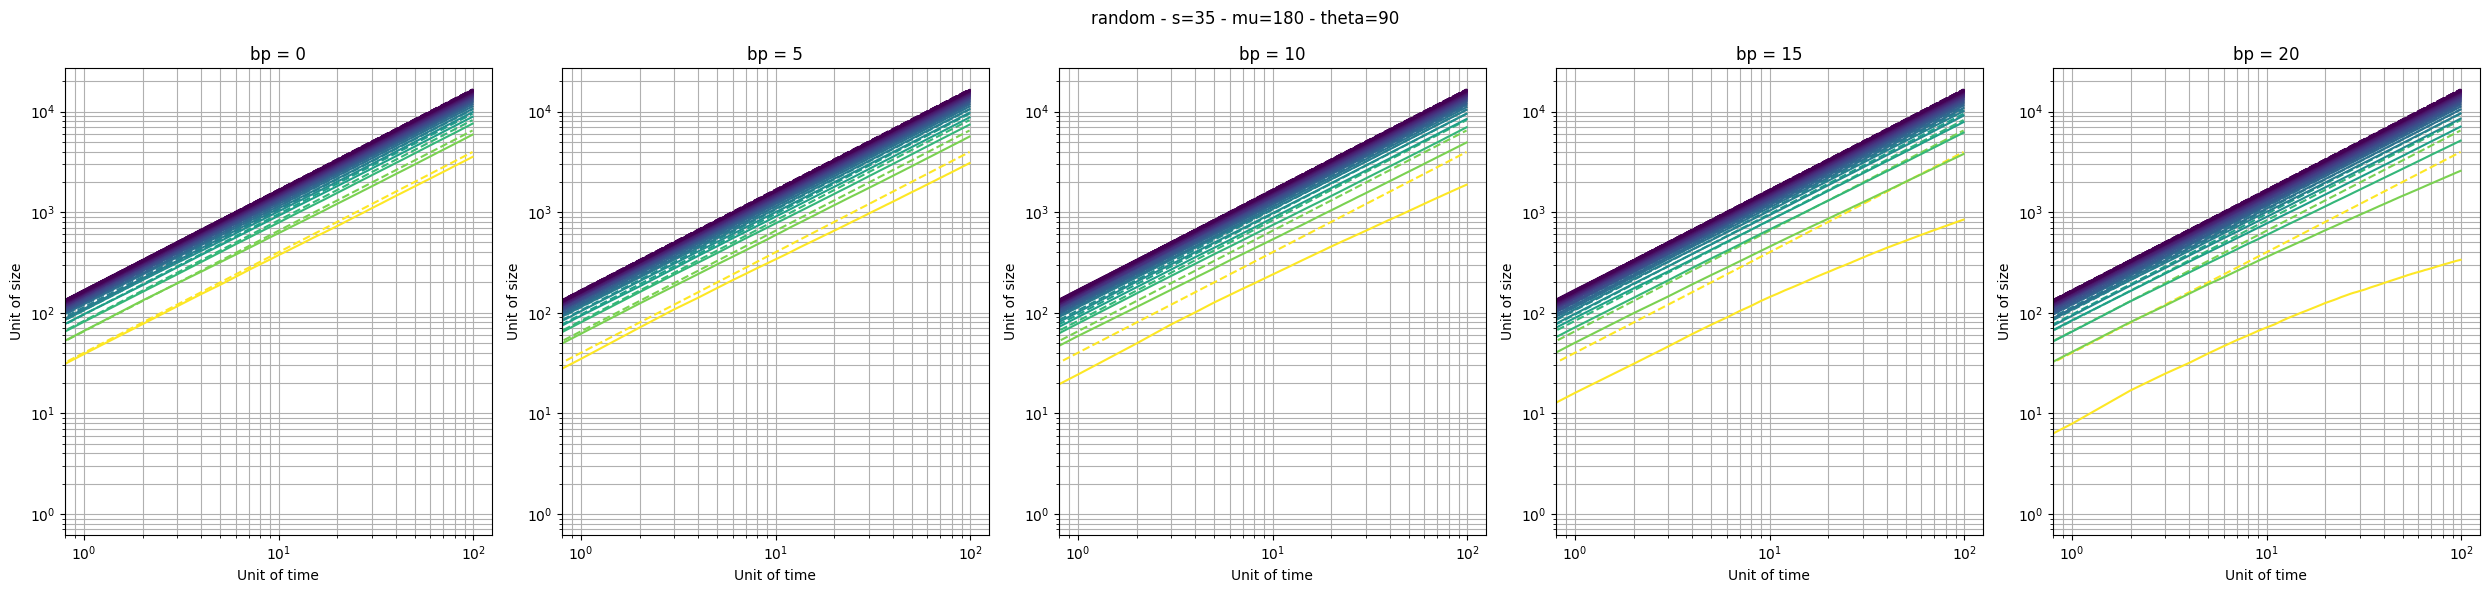

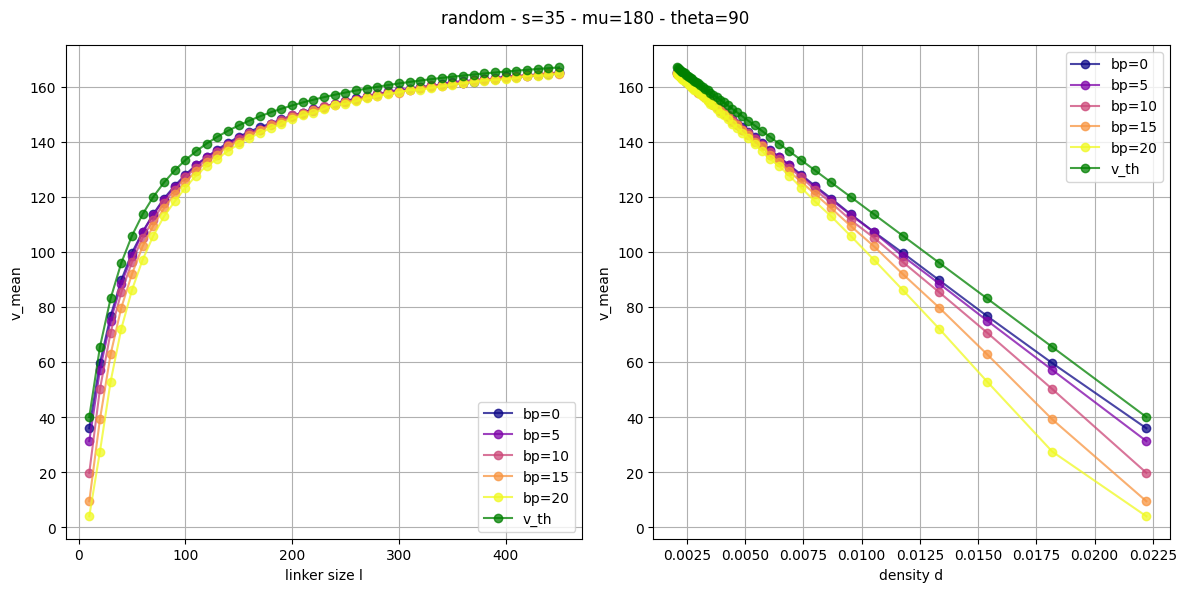

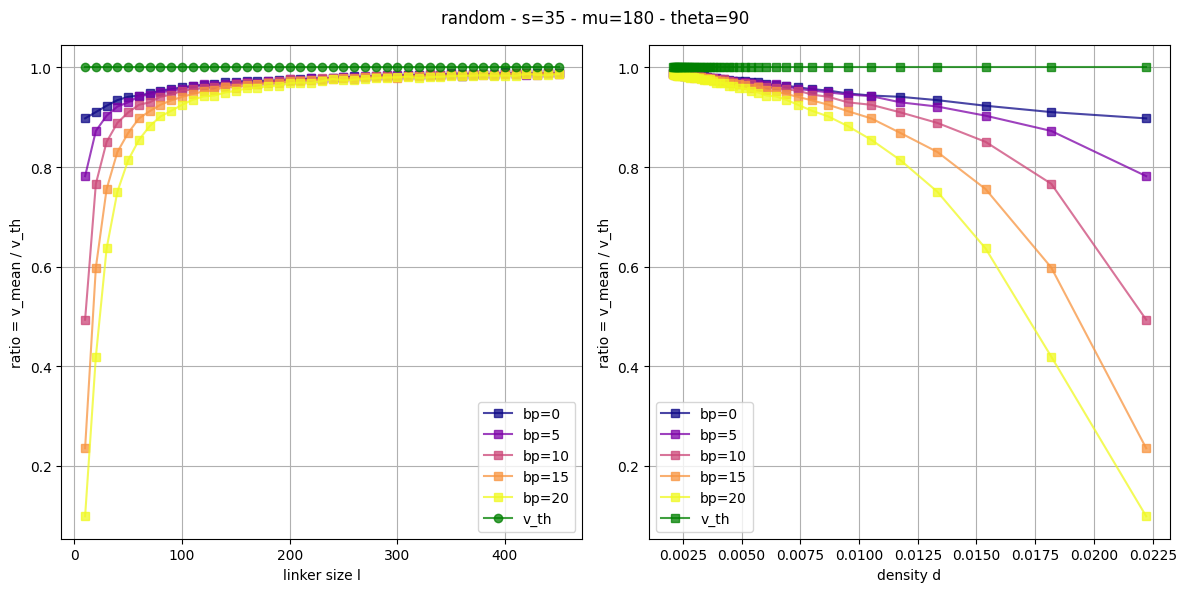

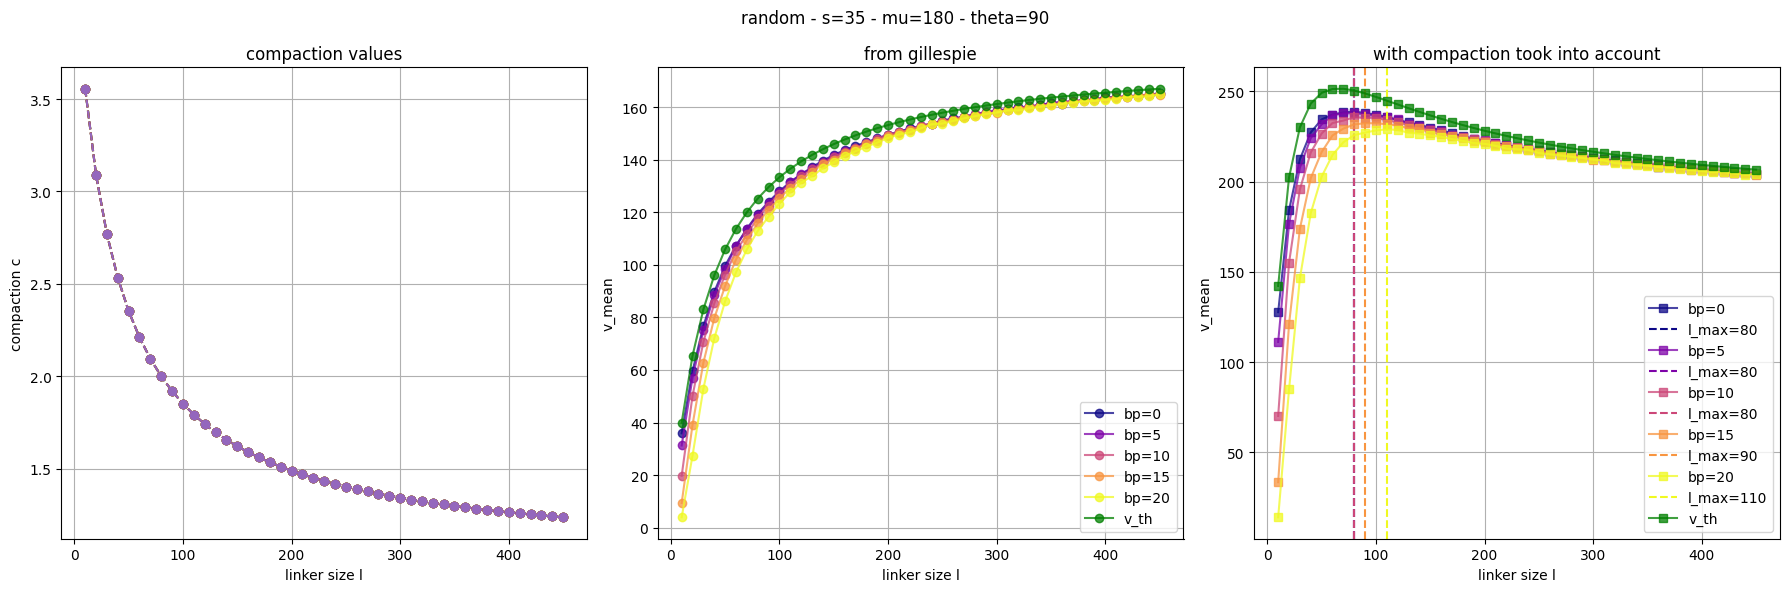

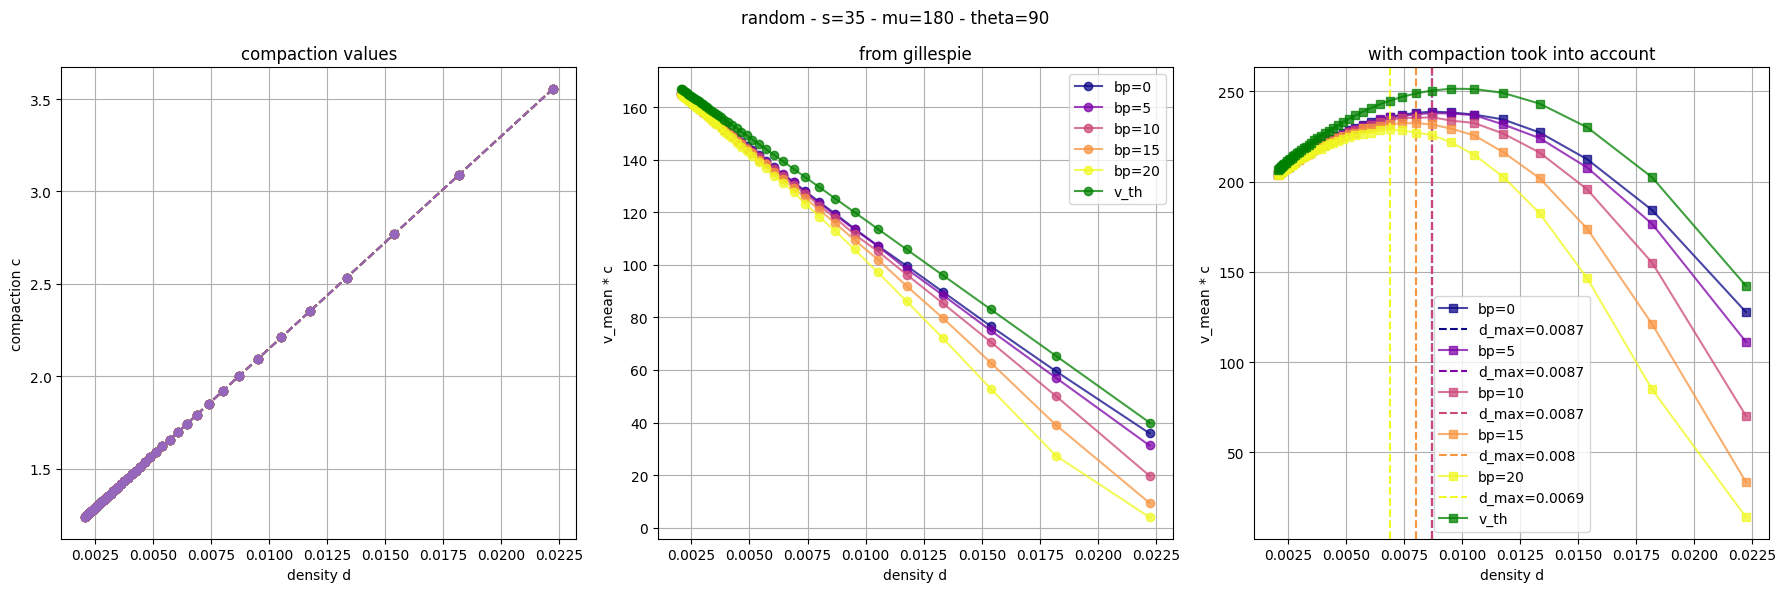

In [ ]:
# ─────────────────────────────────────────────
# 3.3 : RANDOM - Plots
# ─────────────────────────────────────────────


# ─────────────────────────────────────────────
# 3.3.1 : RANDOM - Trajectories
# ─────────────────────────────────────────────

nc = len(bpmin_values)
fig, axs = plt.subplots(nrows=1, ncols=nc, figsize=(5*nc,6))
plt.suptitle(f"{landscape} - s={s} - mu={mu} - theta={th}")

if nc == 1:
    axs = [axs]

cmap = plt.cm.viridis
norm = plt.Normalize(vmin=min(d), vmax=max(d))

for ax, bp in zip(axs, bpmin_values):
    ax.set_title(f"bp = {bp}")
    results_mean_bp = df_sorted.filter(pl.col("bpmin") == bp)["results_mean"].to_numpy()
    wf_bp = df_sorted.filter(pl.col("bpmin") == bp)["wf"].to_numpy()

    for results, l_val, d_val, v_th_val, wf_val in zip(results_mean_bp, l, d, v_th, wf_bp):
        color = cmap(norm(d_val))
        ax.plot(time, results, label=f"l={l_val} - d={np.round(d_val, 3)} model - wf={wf_val}", ls="-", color=color)
        ax.plot(time, time * v_th_val, label=f"l={l_val} - d={np.round(d_val, 3)} theo - wf={wf_val}", ls="--", color=color)
    ax.set_xlabel("Unit of time")
    ax.set_ylabel("Unit of size")
    # ax.set_ylim([-1_000, 17_500])
    ax.grid(True, which="both")
    ax.loglog(True)
    # ax.legend(title="linkersize - density", ncol=2, fontsize=8)

plt.tight_layout()
plt.show()


# ─────────────────────────────────────────────
# 3.3.2 : RANDOM - v_mean and vi_med
# ─────────────────────────────────────────────

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
plt.suptitle(f"{landscape} - s={s} - mu={mu} - theta={th}")

cmap = plt.cm.cmap = plt.cm.plasma
norm = plt.Normalize(vmin=min(bpmin_values), vmax=max(bpmin_values))

for bp in bpmin_values:
    color           = cmap(norm(bp))
    df_plot         = df_sorted.filter(pl.col("bpmin") == bp)
    l               = df_plot["l"].to_numpy()
    s               = df_plot["s"].to_numpy()[0]
    d               = 1 / (s + l)
    v_mean          = df_plot["v_mean"]
    v_th            = mu * d * l
    ratio           = v_mean / v_th
    axs[0].plot(l, v_mean, color=color, label=f"bp={bp}", marker="o", alpha=0.75)
    axs[1].plot(d, v_mean, color=color, label=f"bp={bp}", marker="o", alpha=0.75)
    
axs[0].plot(l, v_th, color="g", label="v_th", marker="o", alpha=0.75)
axs[1].plot(d, v_th, color="g", label="v_th", marker="o", alpha=0.75)

axs[0].set_xlabel("linker size l")
axs[0].set_ylabel("v_mean")
axs[0].grid(True, which="both")
axs[0].legend()
# axs[0].loglog(False)

axs[1].set_xlabel("density d")
axs[1].set_ylabel("v_mean")
axs[1].grid(True, which="both")
axs[1].legend()
# axs[1].loglog(False)

plt.tight_layout()
plt.show()


# ─────────────────────────────────────────────
# 3.3.3 : RANDOM - ratio of v_th and v_model
# ─────────────────────────────────────────────

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle(f"{landscape} - s={s} - mu={mu} - theta={th}")

cmap = plt.cm.cmap = plt.cm.plasma
norm = plt.Normalize(vmin=min(bpmin_values), vmax=max(bpmin_values))

for bp in bpmin_values:
    color           = cmap(norm(bp))
    df_plot         = df_sorted.filter(pl.col("bpmin") == bp)
    l               = df_plot["l"].to_numpy()
    s               = df_plot["s"].to_numpy()[0]
    d               = 1 / (s + l)
    v_mean          = df_plot["v_mean"]
    v_th            = mu * d * l
    ratio           = v_mean / v_th

    axs[0].plot(l, ratio, color=color, label=f"bp={bp}", marker="s", alpha=0.75)
    axs[1].plot(d, ratio, color=color, label=f"bp={bp}", marker="s", alpha=0.75)
    
axs[0].plot(l, v_th / v_th, color="g", label="v_th", marker="o", alpha=0.75)
axs[1].plot(d, v_th / v_th, color="g", label="v_th", marker="s", alpha=0.75)

axs[0].set_xlabel("linker size l")
axs[0].set_ylabel("ratio = v_mean / v_th")
axs[0].grid(True, which="both")
axs[0].legend()

axs[1].set_xlabel("density d")
axs[1].set_ylabel("ratio = v_mean / v_th")
axs[1].grid(True, which="both")
axs[1].legend()

plt.tight_layout()
plt.show()


# ─────────────────────────────────────────────
# 3.3.4 : RANDOM - c + v_mean + v_mean_bp + via l
# ─────────────────────────────────────────────

fig, axs = plt.subplots(1, 3, figsize=(18,6))
plt.suptitle(f"{landscape} - s={s} - mu={mu} - theta={th}")
cmap = plt.cm.cmap = plt.cm.plasma
norm = plt.Normalize(vmin=min(bpmin_values), vmax=max(bpmin_values))

for bp in bpmin_values:
    color           = cmap(norm(bp))
    df_plot         = df_sorted.filter(pl.col("bpmin") == bp)
    l               = df_plot["l"].to_numpy()
    s               = df_plot["s"].to_numpy()[0]
    d               = 1 / (s + l)
    v_mean          = df_plot["v_mean"]
    v_th            = mu * d * l
    ratio           = v_mean / v_th
    d               = 1 / (s + l)
    c               = (150 + l) / (35 + l)
    v_mean_bp       = v_mean * c
    axs[0].plot(l, c, "o--")
    # axes[1].plot(l, v_th, "o--", label="theoretical", alpha=0.75)
    axs[1].plot(l, v_mean, color=color, marker="o", label=f"bp={bp}", alpha=0.75)
    # axes[2].plot(l, v_th * c, "s--", label="v_th * c", alpha=0.75)
    axs[2].plot(l, v_mean_bp, color=color, marker="s", label=f"bp={bp}", alpha=0.75)
    axs[2].axvline(l[np.argmax(v_mean_bp)], color=color, ls="--", label=f"l_max={l[np.argmax(v_mean_bp)]}")
    
axs[1].plot(l, v_th, color="g", label="v_th", marker="o", alpha=0.75)
axs[2].plot(l, v_th * c, color="g", label="v_th", marker="s", alpha=0.75)

axs[0].set_xlabel("linker size l")
axs[0].set_ylabel("compaction c")
axs[0].set_title("compaction values")
axs[0].grid(True, which="both")

axs[1].set_xlabel("linker size l")
axs[1].set_ylabel("v_mean")
axs[1].set_title("from gillespie")
axs[1].grid(True, which="both")
axs[1].legend()

axs[2].set_xlabel("linker size l")
axs[2].set_ylabel("v_mean")
axs[2].set_title("with compaction took into account")
axs[2].grid(True, which="both")
# axs[2].loglog(True)
axs[2].legend()

plt.tight_layout()
plt.show()


# ─────────────────────────────────────────────
# 3.3.5 : RANDOM - c + v_mean + v_mean_bp + via d
# ─────────────────────────────────────────────

fig, axs = plt.subplots(1, 3, figsize=(18,6))
plt.suptitle(f"{landscape} - s={s} - mu={mu} - theta={th}")
cmap = plt.cm.cmap = plt.cm.plasma
norm = plt.Normalize(vmin=min(bpmin_values), vmax=max(bpmin_values))

for bp in bpmin_values:
    color           = cmap(norm(bp))
    df_plot         = df_sorted.filter(pl.col("bpmin") == bp)
    l               = df_plot["l"].to_numpy()
    s               = df_plot["s"].to_numpy()[0]
    d               = 1 / (s + l)
    v_mean          = df_plot["v_mean"]
    v_th            = mu * d * l
    ratio           = v_mean / v_th
    d               = 1 / (s + l)
    c               = (150 + l) / (35 + l)
    v_mean_bp       = v_mean * c
    axs[0].plot(d, c, "o--")
    # axes[1].plot(l, v_th, "o--", label="theoretical", alpha=0.75)
    axs[1].plot(d, v_mean, color=color, marker="o", label=f"bp={bp}", alpha=0.75)
    # axes[2].plot(l, v_th * c, "s--", label="v_th * c", alpha=0.75)
    axs[2].plot(d, v_mean_bp, color=color, marker="s", label=f"bp={bp}", alpha=0.75)
    axs[2].axvline(d[np.argmax(v_mean_bp)], color=color, ls="--", label=f"d_max={np.round(d[np.argmax(v_mean_bp)],4)}")

axs[1].plot(d, v_th, color="g", label="v_th", marker="o", alpha=0.75)
axs[2].plot(d, v_th * c, color="g", label="v_th", marker="s", alpha=0.75)

axs[0].set_xlabel("density d")
axs[0].set_ylabel("compaction c")
axs[0].set_title("compaction values")
axs[0].grid(True, which="both")

axs[1].set_xlabel("density d")
axs[1].set_ylabel("v_mean * c")
axs[1].set_title("from gillespie")
axs[1].grid(True, which="both")
axs[1].legend()

axs[2].set_xlabel("density d")
axs[2].set_ylabel("v_mean * c")
axs[2].set_title("with compaction took into account")
axs[2].grid(True, which="both")
# axs[2].loglog(True)
axs[2].legend()

plt.tight_layout()
plt.show()

shape: (198, 71)
┌───────────┬───────────┬─────┬─────┬───┬───────────────────┬─────────────┬───────────┬────────────┐
│ formalism ┆ landscape ┆ s   ┆ l   ┆ … ┆ xt_over_t         ┆ G           ┆ bound_low ┆ bound_high │
│ ---       ┆ ---       ┆ --- ┆ --- ┆   ┆ ---               ┆ ---         ┆ ---       ┆ ---        │
│ str       ┆ str       ┆ i64 ┆ i64 ┆   ┆ list[f64]         ┆ list[f64]   ┆ i64       ┆ i64        │
╞═══════════╪═══════════╪═════╪═════╪═══╪═══════════════════╪═════════════╪═══════════╪════════════╡
│ 1         ┆ periodic  ┆ 35  ┆ 10  ┆ … ┆ [39.8296,         ┆ [0.997983,  ┆ 5         ┆ 80         │
│           ┆           ┆     ┆     ┆   ┆ 39.77395, …       ┆ 0.968909, … ┆           ┆            │
│           ┆           ┆     ┆     ┆   ┆ 39.99465…         ┆ 1.01330…    ┆           ┆            │
│ 1         ┆ periodic  ┆ 35  ┆ 10  ┆ … ┆ [56.7548, 55.504, ┆ [0.967849,  ┆ 5         ┆ 80         │
│           ┆           ┆     ┆     ┆   ┆ … 49.914308]      ┆ 0.919396, … 

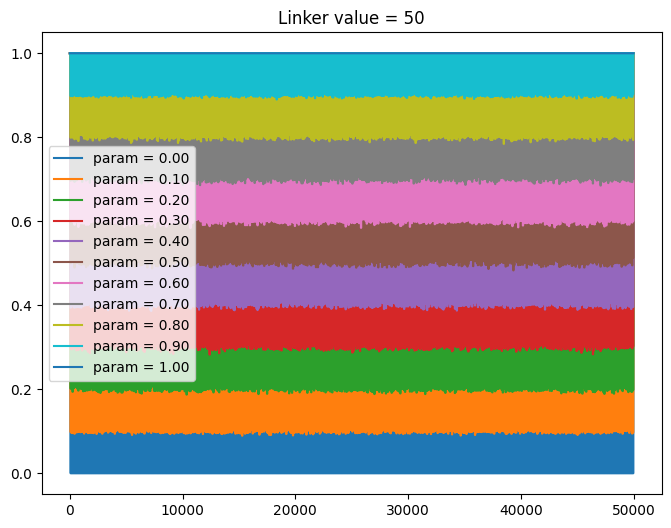

In [73]:
# ─────────────────────────────────────────────
# 4.1 : PERIODIC - Reading File
# ─────────────────────────────────────────────

# DataFrame
root = Path("/home/nicolas/Documents/PhD/Workspace/nucleo/outputs/2025-11-13__PC/nucleo__accessperiodic_0")
paths = [str(p) for p in root.glob("*/**/*.parquet")] or [str(p) for p in root.glob("*/*.parquet")]
df_sorted = (
    pl.scan_parquet(paths)
    .filter((pl.col("landscape") == "periodic") & (pl.col("nt") == 10_000))
    .collect()
    .sort(by=["landscape", "l", "parameter"],
          descending=[False, False, False]
        )
)

print(df_sorted)
print(df_sorted.columns)


# ─────────────────────────────────────────────
# 4.2 : PERIODIC - Verification of the obstacles
# ─────────────────────────────────────────────

plt.figure(figsize=(8,6))

l_value = 50
df_sub = df_sorted.filter(pl.col("l") == l_value)

for row in df_sub.iter_rows(named=True):
    alpha_mean_sim  = row["alpha_mean_sim"]
    parameter       = row["parameter"]
    alpha_value     = np.mean(alpha_mean_sim)
    
    plt.plot(alpha_mean_sim, alpha=1, label=f"param = {parameter:.2f}")
    print(f"parameter = {parameter:.2f} - alpha_value = {alpha_value:.2f} - {alpha_mean_sim[0:100]}")

plt.title(f"Linker value = {l_value}")
plt.legend()
plt.show()

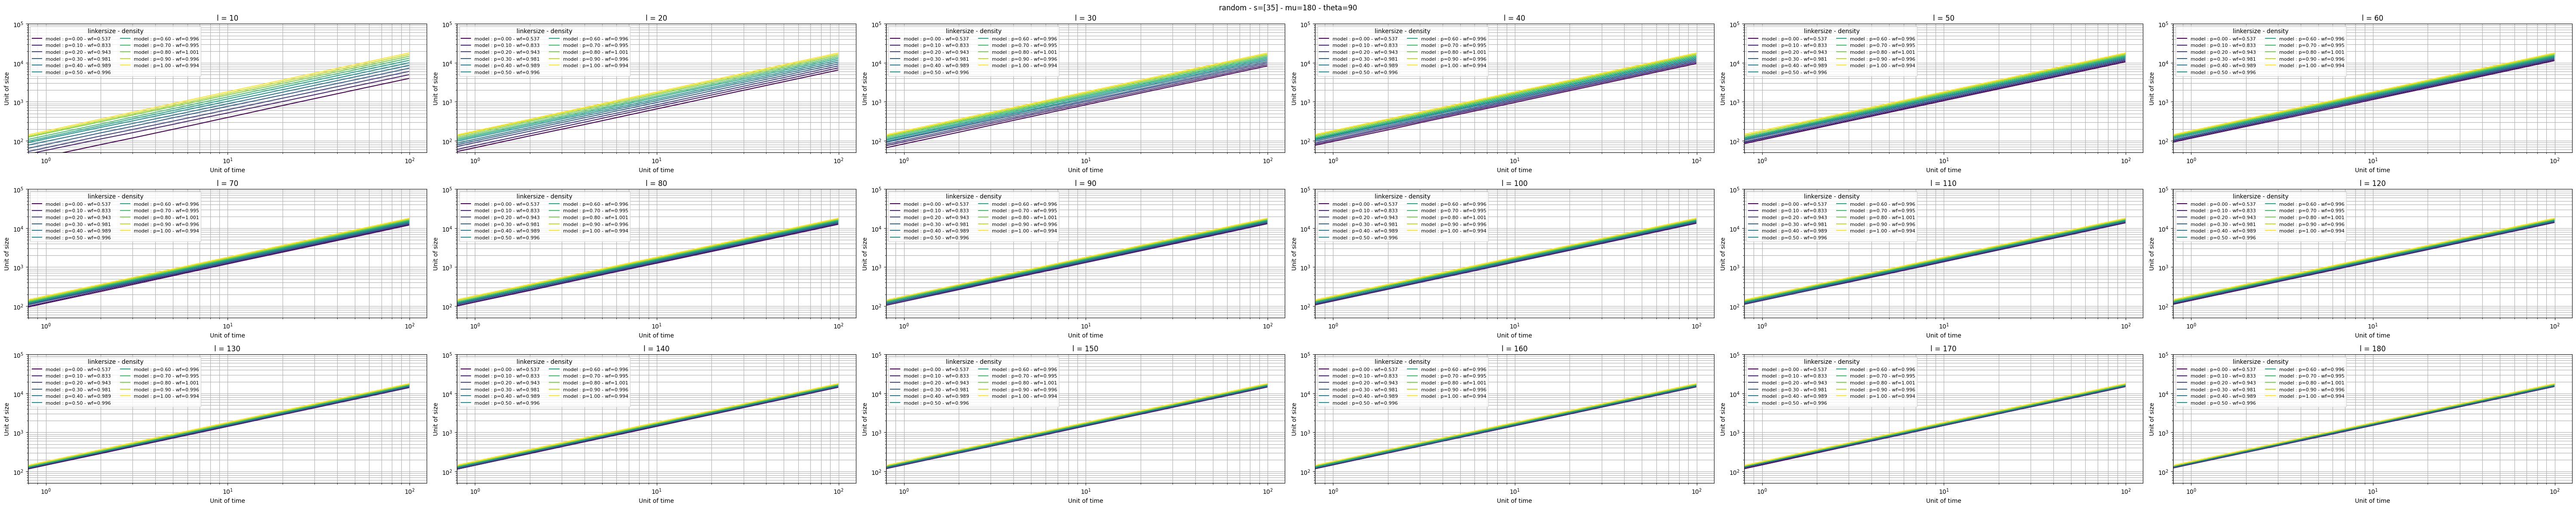

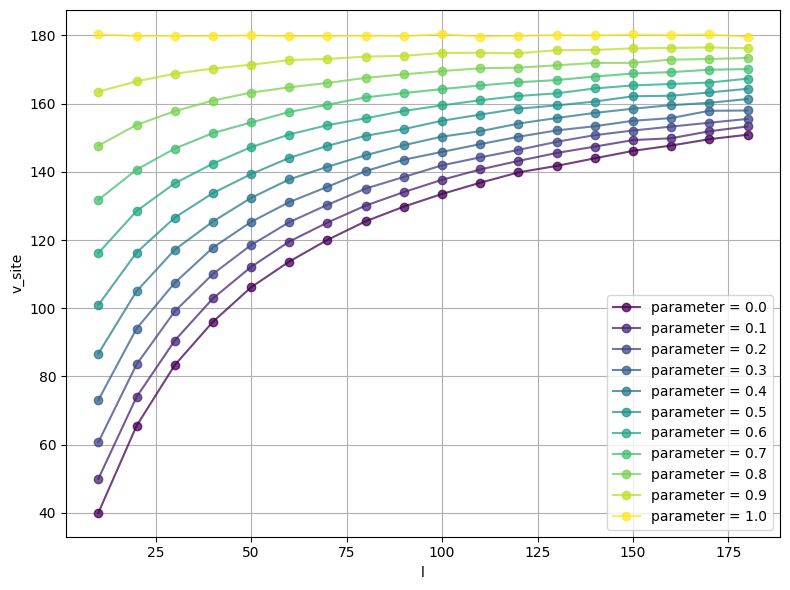

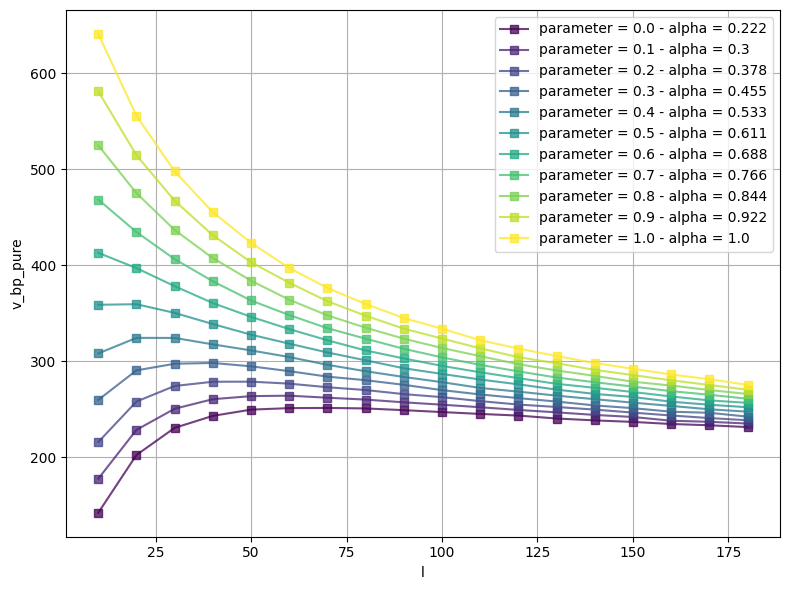

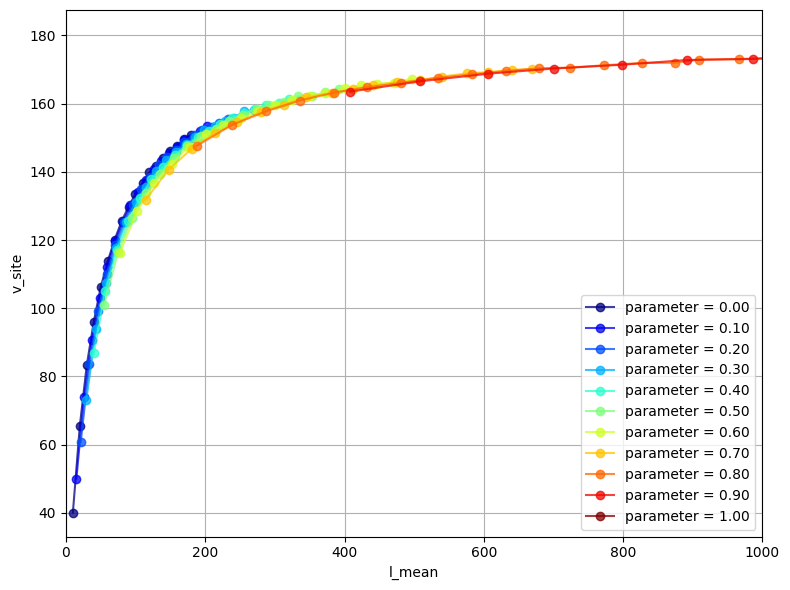

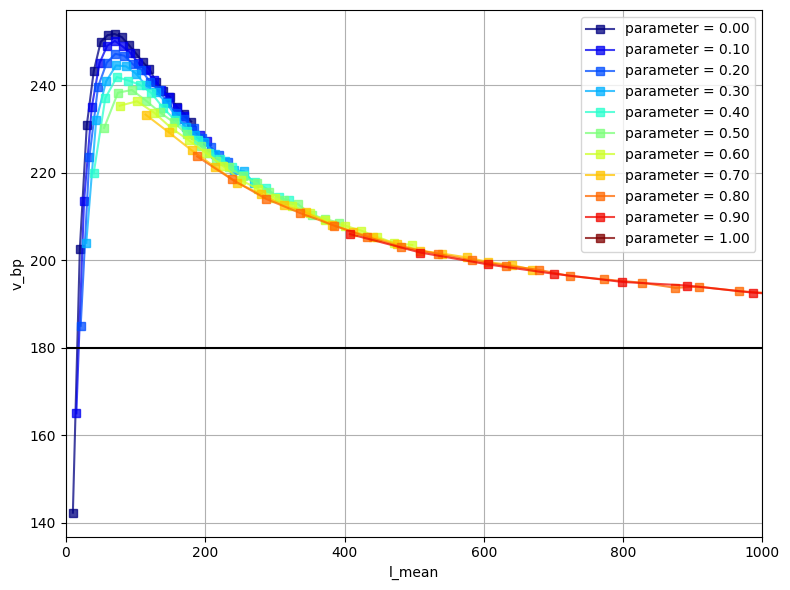

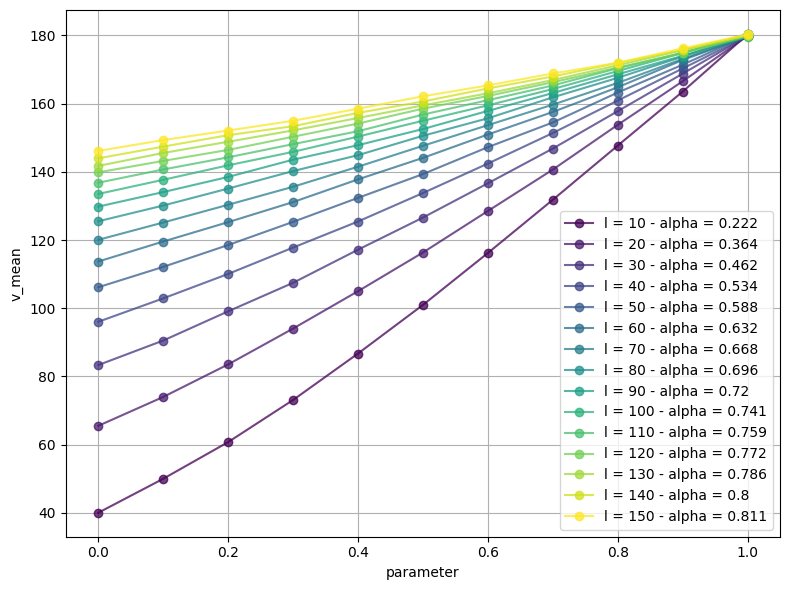

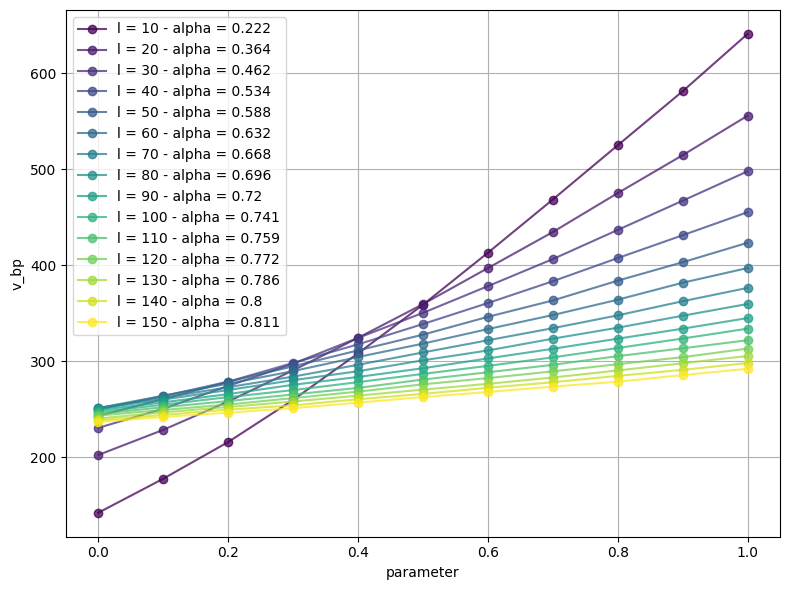

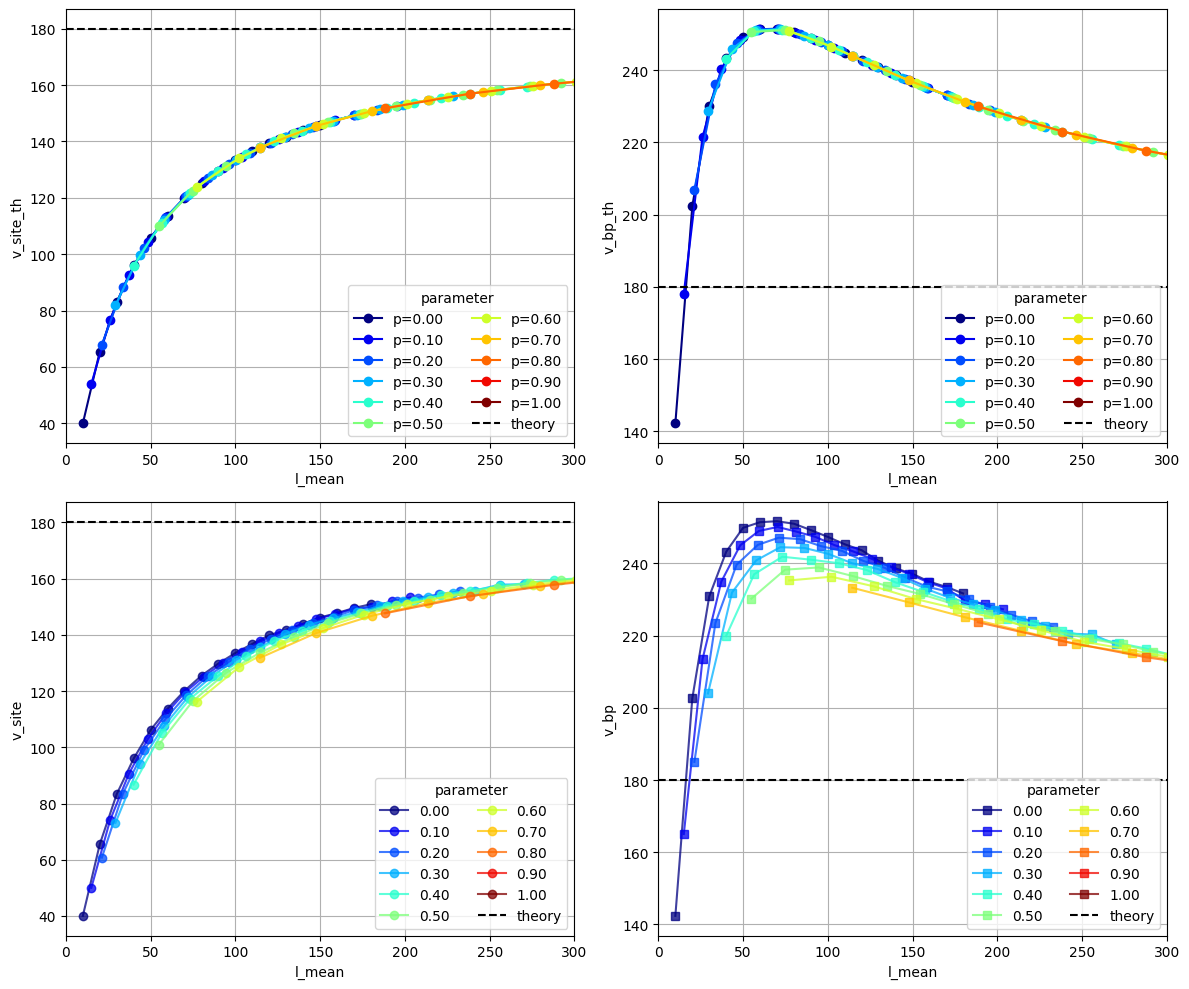

In [93]:
# ─────────────────────────────────────────────
# 4.3 : PERIODIC - Plots
# ─────────────────────────────────────────────


# ─────────────────────────────────────────────
# 4.3.1 : PERIODIC - Trajectories
# ─────────────────────────────────────────────

s        = df_sorted["s"].to_numpy()
s_values = np.unique(s)
l        = df_sorted["l"].to_numpy()
l_values = np.unique(l)
p        = df_sorted["parameter"].to_numpy()
p_values = np.unique(p)

nr = 3
nc = int(np.ceil(len(l_values) / nr))
fig, axs = plt.subplots(nrows=nr, ncols=nc, figsize=(10*nc, 12))
plt.suptitle(f"{landscape} - s={s_values} - mu={mu} - theta={th}")
axs = np.array(axs).reshape(-1)

cmap = plt.cm.viridis
norm = plt.Normalize(vmin=min(p_values), vmax=max(p_values))

for ax, l_val in zip(axs, l_values):
    # Filtrage des données pour ce l
    df_l = df_sorted.filter(pl.col("l") == l_val)
    results_mean_l = df_l["results_mean"].to_numpy()
    wf_l = df_l["wf"].to_numpy()

    for results, p_val, v_th_val, wf_val in zip(results_mean_l, p, v_th, wf_bp):
        color = cmap(norm(p_val))

        # courbe modèle
        ax.plot(
            time, results,
            label=f"model : p={p_val:.2f} - wf={wf_val}",
            ls="-", color=color
        )

        # # courbe théorie
        # ax.plot(
        #     time, time * v_th_val,
        #     label=f" theo : p={p_val:.2f} - wf={wf_val}",
        #     ls="--", color=color
        # )
        
    ax.set_ylim([5e1, 1e5])
    ax.set_title(f"l = {l_val}")
    ax.set_xlabel("Unit of time")
    ax.set_ylabel("Unit of size")
    ax.grid(True, which="both")

    # correction de ax.loglog()
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.legend(title="linkersize - density", ncol=2, fontsize=8)

plt.tight_layout()
plt.show()


# ─────────────────────────────────────────────
# 4.3.2.1 : PERIODIC - Speed in function of linkers : l
# ─────────────────────────────────────────────

# Colors
cmap = plt.cm.viridis
values = sorted(df_sorted["parameter"].unique().to_numpy())
norm = plt.Normalize(min(values), max(values))


# Sites

plt.figure(figsize=(8,6))

for group in df_sorted.partition_by("parameter", as_dict=False):
    
    parameter   = group["parameter"][0]
    l           = group["l"].to_numpy()
    mu          = group["mu"][0]
    v_site      = group["v_mean"].to_numpy()
    alpha_mean_sim  = group["alpha_mean_sim"].to_numpy()[0]
    color       = cmap(norm(parameter))
    
    plt.plot(l, v_site, c=color, marker="o", ls="-", alpha=0.75,
             label=f"parameter = {np.round(parameter, 3)}"
    )
    
    v_th        = mu * alpha_value

    # plt.plot(l, v_th, c=color, marker="s", ls="--", alpha=0.75,
    #          label=f"alpha = {np.round(alpha_value, 3)}"
    # )
    
plt.xlabel("l")
plt.ylabel("v_site")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Base pairs

plt.figure(figsize=(8,6))

for group in df_sorted.partition_by("parameter", as_dict=False):
    parameter       = group["parameter"][0]
    s               = group["s"].to_numpy()
    l               = group["l"].to_numpy()
    v_site          = group["v_mean"].to_numpy()
    alpha_mean_sim  = group["alpha_mean_sim"].to_numpy()[0]
    c           = (150 + l) / (35 + l)
    v_bp_pure   = v_site * c
    alpha_value = np.mean(alpha_mean_sim)
    color       = cmap(norm(parameter))
    
    plt.plot(l, v_bp_pure, c=color, marker="s", 
             label=f"parameter = {np.round(parameter, 3)} - alpha = {np.round(alpha_value, 3)}", 
             alpha=0.75
    )

plt.xlabel("l")
plt.ylabel("v_bp_pure")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# ─────────────────────────────────────────────
# 4.3.2.2 : PERIODIC - Speed in function of linkers : l_mean
# ─────────────────────────────────────────────

# Colors
cmap = plt.cm.jet
values = sorted(df_sorted["parameter"].unique().to_numpy())
norm = plt.Normalize(min(values), max(values))


# Sites

plt.figure(figsize=(8,6))

for group in df_sorted.partition_by("parameter", as_dict=False):
    
    parameter       = group["parameter"][0]
    l_mean          = group["l_mean"].to_numpy()
    v_site          = group["v_mean"].to_numpy()
    color           = cmap(norm(parameter))
    
    plt.plot(l_mean, v_site, c=color, marker="o", ls="-", alpha=0.75,
             label=f"parameter = {parameter:.2f}"
    )

plt.xlim([0,1_000])
plt.xlabel("l_mean")
plt.ylabel("v_site")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Base pairs

plt.figure(figsize=(8,6))

for group in df_sorted.partition_by("parameter", as_dict=False):
    
    parameter       = group["parameter"][0]
    l_mean          = group["l_mean"].to_numpy()
    v_site          = group["v_mean"].to_numpy()
    color           = cmap(norm(parameter))
     
    c               = (150 + l_mean) / (35 + l_mean)
    v_bp            = v_site * c
    
    plt.plot(l_mean, v_bp, c=color, marker="s", ls="-", alpha=0.75,
             label=f"parameter = {parameter:.2f}"
    )

plt.axhline(y=180, c="k")
plt.xlim([0,1_000])
plt.xlabel("l_mean")
plt.ylabel("v_bp")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# ─────────────────────────────────────────────
# 4.3.2.3 : PERIODIC - Speed in function of parameters : p
# ─────────────────────────────────────────────

# Values of l
df_subset = df_sorted.filter((pl.col("l") >= 5) & (pl.col("l") <= 150))

# Colors
cmap = plt.cm.viridis
values = sorted(df_subset["l"].unique().to_numpy())
norm = plt.Normalize(min(values), max(values))


# Sites

plt.figure(figsize=(8, 6))

for group in df_subset.partition_by("l", as_dict=False):
    l               = group["l"][0]
    parameter       = group["parameter"].to_numpy()
    v_site          = group["v_mean"].to_numpy()
    alpha_mean_sim  = group["alpha_mean_sim"].to_numpy()[0]
    alpha_value     = np.mean(alpha_mean_sim[10_000 : 20_000])
    color           = cmap(norm(l))
    
    # plt.plot(parameter, v_site, c=color, marker="o", 
    #          label=f"l = {np.round(l, 3)}"
    #          , alpha=0.75
    # )
    
    plt.plot(parameter, v_site, c=color, marker="o", 
            label=f"l = {np.round(l, 3)} - alpha = {np.round(alpha_value, 3)}"
            , alpha=0.75
    )

plt.xlabel("parameter")
plt.ylabel("v_mean")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Base pairs

plt.figure(figsize=(8,6))

for group in df_subset.partition_by("l", as_dict=False):
    l               = group["l"][0]
    parameter       = group["parameter"].to_numpy()
    v_site          = group["v_mean"].to_numpy()
    alpha_mean_sim  = group["alpha_mean_sim"].to_numpy()[0]
    alpha_value     = np.mean(alpha_mean_sim[10_000 : 20_000])
    c               = (150 + l) / (35 + l)
    v_bp            = v_site * c  
    color           = cmap(norm(l))
    
    plt.plot(parameter, v_bp, c=color, marker="o", 
            label=f"l = {np.round(l, 3)} - alpha = {np.round(alpha_value, 3)}"
            , alpha=0.75
    )

plt.xlabel("parameter")
plt.ylabel("v_bp")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# ─────────────────────────────────────────────
# 4.3.2.4 : PERIODIC - Main results
# ─────────────────────────────────────────────

# --- Préparation couleurs ---
cmap = plt.cm.jet
values = sorted(df_sorted["parameter"].unique().to_numpy())
norm = plt.Normalize(min(values), max(values))

# --- Début figure ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
(ax1, ax2), (ax3, ax4) = axes
xmax= 300

# 1. v_th_eff vs l_mean
for group in df_subset.partition_by("parameter", as_dict=False):
    l_mean      = group["l_mean"]
    v_th_eff    = group["v_th_eff"]
    parameter   = group["parameter"][0]
    color       = cmap(norm(parameter))
    ax1.plot(l_mean, v_th_eff, c=color, label=f"p={parameter:.2f}", marker="o")

ax1.axhline(y=180, c="k", ls="--", label="theory")
ax1.set_xlim([0,xmax])
ax1.set_xlabel("l_mean")
ax1.set_ylabel("v_site_th")
ax1.legend(title="parameter", ncols=2)
ax1.grid(True)

# 2. v_th = v_th_eff * c
for group in df_subset.partition_by("parameter", as_dict=False):
    l_mean      = group["l_mean"]
    v_th_eff    = group["v_th_eff"]
    parameter   = group["parameter"][0]
    c           = (150 + l_mean) / (35 + l_mean)
    v_th        = v_th_eff * c
    color       = cmap(norm(parameter))
    ax2.plot(l_mean, v_th, c=color, label=f"p={parameter:.2f}", marker="o")

ax2.axhline(y=180, c="k", ls="--", label="theory")
ax2.set_xlim([0,xmax])
ax2.set_xlabel("l_mean")
ax2.set_ylabel("v_bp_th")
ax2.legend(title="parameter", ncols=2)
ax2.grid(True)

# 3. v_site vs l_mean (couleurs par paramètre)
for group in df_sorted.partition_by("parameter", as_dict=False):
    parameter       = group["parameter"][0]
    l_mean          = group["l_mean"].to_numpy()
    v_site          = group["v_mean"].to_numpy()
    color           = cmap(norm(parameter))
    
    ax3.plot(l_mean, v_site, c=color, marker="o", ls="-", alpha=0.75,
             label=f"{parameter:.2f}")

ax3.axhline(y=180, c="k", ls="--", label="theory")
ax3.set_xlim([0,xmax])
ax3.set_xlabel("l_mean")
ax3.set_ylabel("v_site")
ax3.grid(True)
ax3.legend(title="parameter", ncols=2)

# 4. v_bp (base pairs) = v_site * c
for group in df_sorted.partition_by("parameter", as_dict=False):
    parameter       = group["parameter"][0]
    l_mean          = group["l_mean"].to_numpy()
    v_site          = group["v_mean"].to_numpy()
    color           = cmap(norm(parameter))

    c               = (150 + l_mean) / (35 + l_mean)
    v_bp            = v_site * c
    
    ax4.plot(l_mean, v_bp, c=color, marker="s", ls="-", alpha=0.75,
             label=f"{parameter:.2f}")

ax4.axhline(y=180, c="k", ls="--", label="theory")
ax4.set_xlim([0,xmax])
ax4.set_xlabel("l_mean")
ax4.set_ylabel("v_bp")
ax4.grid(True)
ax4.legend(title="parameter", ncols=2)

plt.tight_layout()
plt.show()

# .